In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.preprocessing import image

from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 69
np.random.seed = seed

# Размеры картинки + каналы
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

C:\Users\incyberworld\AppData\Local\Temp\ipykernel_3312\2350065308.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


Resizing training images and masks


  0%|          | 0/154 [00:00<?, ?it/s]C:\Users\incyberworld\AppData\Local\Temp\ipykernel_3312\2350065308.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████| 154/154 [00:19<00:00,  7.90it/s]


Resizing test images


100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


Done!


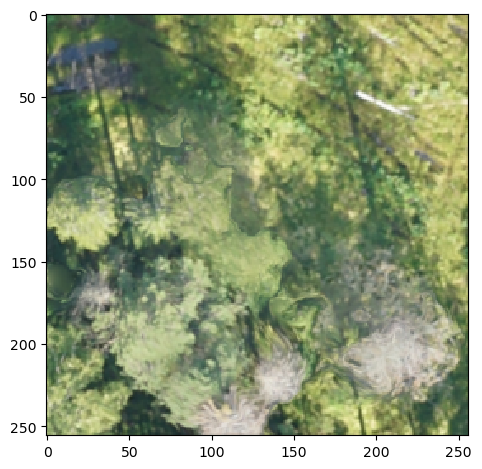

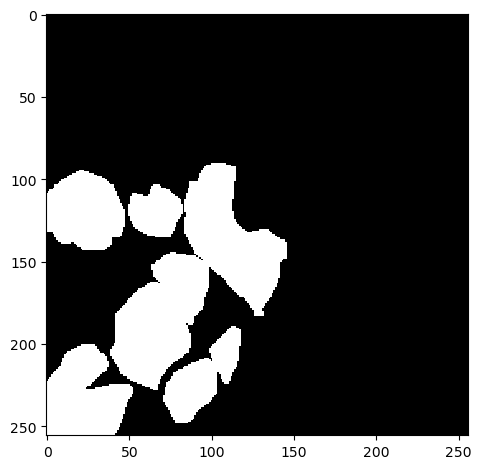

In [2]:
TRAIN_PATH = 'data/dataset/'
TEST_PATH = 'data/dataset_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# Ресайз + кроп изображений и масок
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/image/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

# Ресайз + кроп изображений для теста
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

#Отображение
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()


In [3]:
#Build the model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255)(inputs)

# Структура модели нейронной сети построенна на классической модели U-net, решающая проблему сегментации
# изначально предназначалась для сегментации медицинских изображений.
# Модель содержит сверточную и разверточную части, каждый из которых связан со следующим.

# Еще одной причиной выбирать U-net - является возможность обучения задачи сегментации на маленьком
# наборе данных.

#Contraction path
# Слой свертки проходит по изображению с ядром (3,3), в резульате получается карта фич.
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1) # Слой дропаут для решения проблем переобучения
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1) # Пулинг уменьшает размер получившийся фича мапы
# На данном этапе уже имеем 4640 параметров доступных для тренировки
# Такая структура позволяет нейронной сети сфокусироваться на том что она видит, а не на том
# где конкретно это находится.
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)
 
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
# Далее идет слой развертки полученного, как называют в автоэнкодерах - вектора фич
# обратно в изображение. Шаг позволяет получить изображение карты сегментации в разрешении
# равном исходному.
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4]) #Конкатенация послойна, самый нижний слой с самым нижним
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
# В результате получаем карту фич, которая разворачивается обратно в карту сегментации.
 
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

# Итоговая нейронная сеть имеет 1.900.000 тренируемых параметров.
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

Epoch 1/10
3/3 [==============================] - 3s 235ms/step - loss: 0.4041 - accuracy: 0.8201 - val_loss: 0.8618 - val_accuracy: 0.5892
Epoch 2/10
3/3 [==============================] - 1s 229ms/step - loss: 0.3985 - accuracy: 0.8229 - val_loss: 0.9062 - val_accuracy: 0.5808
Epoch 3/10
3/3 [==============================] - 1s 231ms/step - loss: 0.3923 - accuracy: 0.8265 - val_loss: 0.7387 - val_accuracy: 0.6059
Epoch 4/10
3/3 [==============================] - 1s 228ms/step - loss: 0.3956 - accuracy: 0.8221 - val_loss: 0.7102 - val_accuracy: 0.6069
Epoch 5/10
3/3 [==============================] - 1s 227ms/step - loss: 0.3895 - accuracy: 0.8265 - val_loss: 0.6399 - val_accuracy: 0.6300
Epoch 6/10
3/3 [==============================] - 1s 228ms/step - loss: 0.3901 - accuracy: 0.8272 - val_loss: 0.7351 - val_accuracy: 0.5924
Epoch 7/10
3/3 [==============================] - 1s 229ms/step - loss: 0.3867 - accuracy: 0.8269 - val_loss: 0.7997 - val_accuracy: 0.5814
Epoch 8/10
3/3 [====

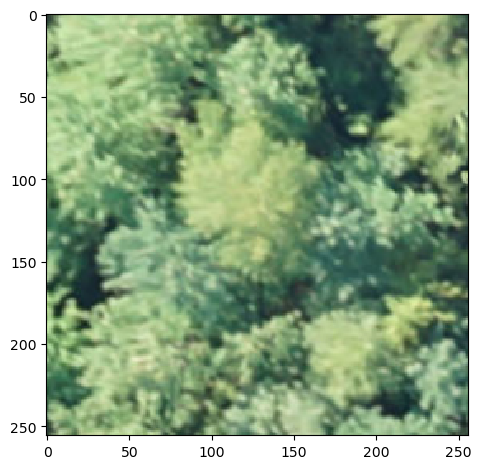

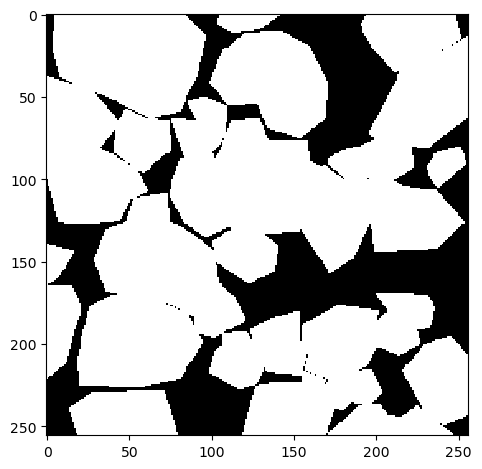

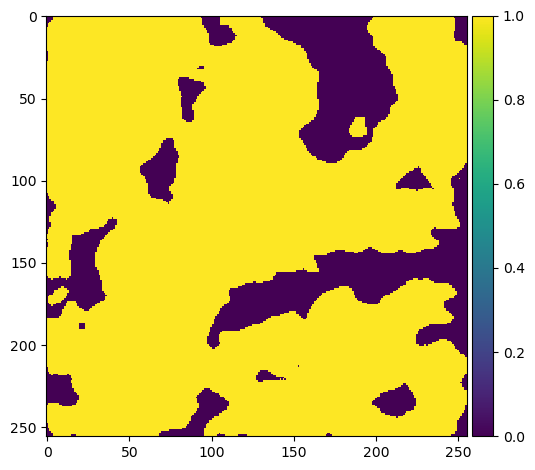

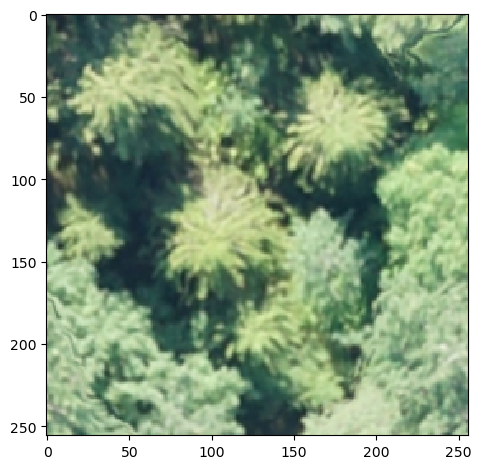

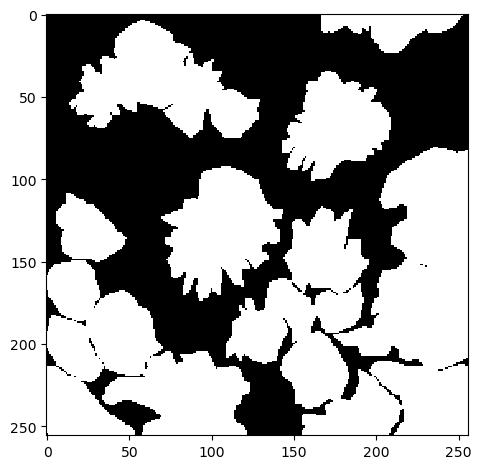

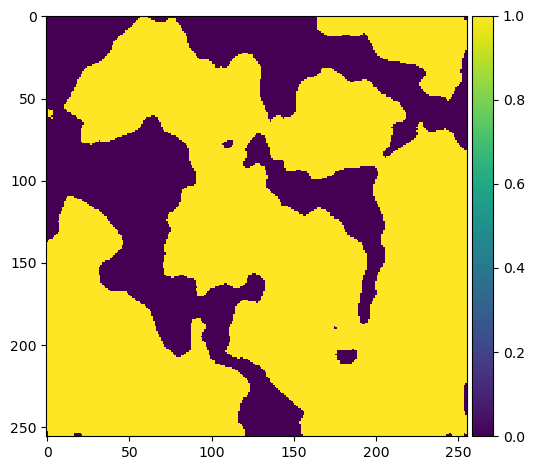

In [6]:
################################
#Modelcheckpoint
# checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

# callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
#         tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=64, epochs=10)

####################################

idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

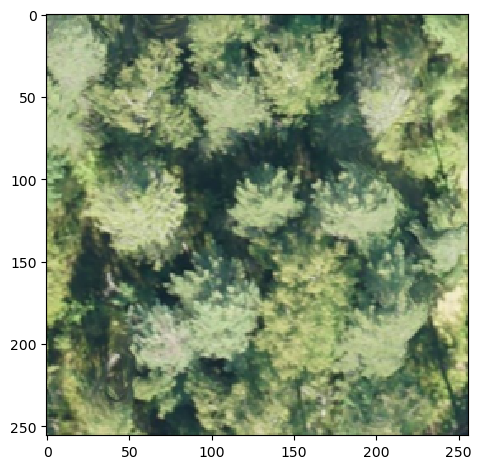

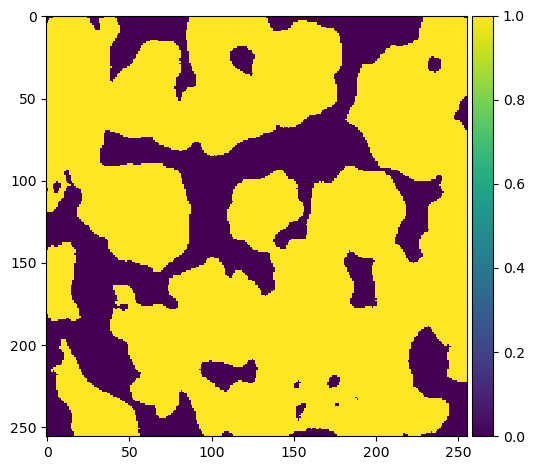

In [11]:
# Вывод изображения из тестового набора данных
imshow(np.squeeze(X_test[0]))
plt.show()
imshow(np.squeeze(preds_test_t[0]))
plt.show()

In [12]:
# Сохранение модели
model.save('checkpoint/hacknet_v2')

INFO:tensorflow:Assets written to: hacknet\assets
